In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import files
files.upload()


Saving customers.csv to customers.csv


{'customers.csv': b'ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation\n462809,Male,No,22,No,Healthcare,1,Low,4,Cat_4,D\n462643,Female,Yes,38,Yes,Engineer,,Average,3,Cat_4,A\n466315,Female,Yes,67,Yes,Engineer,1,Low,1,Cat_6,B\n461735,Male,Yes,67,Yes,Lawyer,0,High,2,Cat_6,B\n462669,Female,Yes,40,Yes,Entertainment,,High,6,Cat_6,A\n461319,Male,Yes,56,No,Artist,0,Average,2,Cat_6,C\n460156,Male,No,32,Yes,Healthcare,1,Low,3,Cat_6,C\n464347,Female,No,33,Yes,Healthcare,1,Low,3,Cat_6,D\n465015,Female,Yes,61,Yes,Engineer,0,Low,3,Cat_7,D\n465176,Female,Yes,55,Yes,Artist,1,Average,4,Cat_6,C\n464041,Female,No,26,Yes,Engineer,1,Low,3,Cat_6,A\n464942,Male,No,19,No,Healthcare,4,Low,4,Cat_4,D\n461230,Female,No,19,No,Executive,0,Low,,Cat_3,D\n459573,Male,Yes,70,No,Lawyer,,Low,1,Cat_6,A\n460849,Female,Yes,58,No,Doctor,0,Low,1,Cat_3,B\n460563,Female,No,41,No,Healthcare,1,Low,2,Cat_1,C\n466865,Female,No,32,No,Homemaker,9,Low,5,Cat_3,D\n461644,Male,N

In [5]:
df = pd.read_csv("customers.csv")
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
le = LabelEncoder()

categorical_cols = [
    'Gender','Ever_Married','Graduated','Profession',
    'Spending_Score','Var_1','Segmentation'
]

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [8]:
df.fillna(df.mean(), inplace=True)

In [9]:
X = df.drop('Segmentation', axis=1)
y = df['Segmentation']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [13]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [15]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [16]:
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=100)

Epoch [10/100], Loss: 1.3169
Epoch [20/100], Loss: 1.3318
Epoch [30/100], Loss: 1.1578
Epoch [40/100], Loss: 1.3817
Epoch [50/100], Loss: 1.1485
Epoch [60/100], Loss: 1.0156
Epoch [70/100], Loss: 1.1470
Epoch [80/100], Loss: 1.1145
Epoch [90/100], Loss: 1.1548
Epoch [100/100], Loss: 1.1249


In [17]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

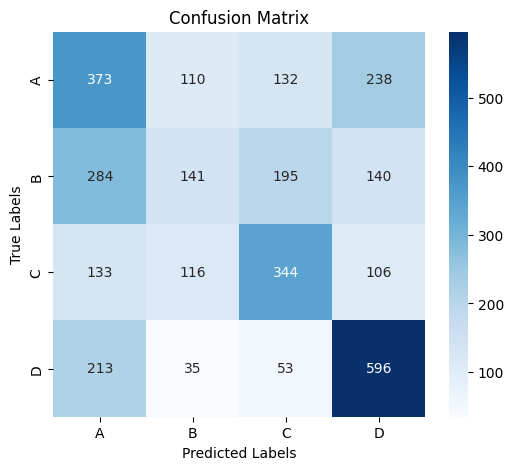

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['A','B','C','D'],
            yticklabels=['A','B','C','D'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=['A','B','C','D']
))

Test Accuracy: 0.45310065440947334

Classification Report:

              precision    recall  f1-score   support

           A       0.37      0.44      0.40       853
           B       0.35      0.19      0.24       760
           C       0.48      0.49      0.48       699
           D       0.55      0.66      0.60       897

    accuracy                           0.45      3209
   macro avg       0.44      0.44      0.43      3209
weighted avg       0.44      0.45      0.44      3209



In [23]:
sample = X_test_tensor[12].unsqueeze(0)

with torch.no_grad():
    output = model(sample)
    _, pred = torch.max(output, 1)
print("Name: SUBHASH V")
print("REG.No: 212224240163")
print("Predicted class for sample input:", chr(pred.item()+65))
print("Actual class for sample input:", chr(y_test_tensor[12].item()+65))

Name: SUBHASH V
REG.No: 212224240163
Predicted class for sample input: D
Actual class for sample input: D
